In [1]:
import numpy as np
import tensorflow as tf
import pylidc

print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)
print("pylidc:", pylidc.__version__)

NumPy: 1.26.4
TensorFlow: 2.19.0
pylidc: 0.2.3


In [2]:
#!pip install pylidc

In [3]:
#!pip install matplotlib ipywidgets

## + Importations

In [4]:
import pandas as pd
import os
import numpy as np
import pylidc as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
from collections import defaultdict
import scipy.ndimage
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Flatten, Dropout, BatchNormalization

# Patch numpy.int to the built-in int
np.int = int

In [5]:
import numpy as np
np.int = int
np.bool= bool

In [6]:
# Define a safer check to ensure we only select scans that exist on disk
def scan_exists(scan):
    try:
        return os.path.exists(scan.get_path_to_dicom_files())
    except RuntimeError:
        return False  # If it raises a RuntimeError, that means the folder doesn't exist

# Only keep scans whose data folders actually exist
scans = [scan for scan in pl.query(pl.Scan).all() if scan_exists(scan)]

### Verifier extraction du dataset

In [7]:
'''# Get a list of patient IDs for the scans that exist on disk
valid_patient_ids = [scan.patient_id for scan in scans if os.path.exists(scan.get_path_to_dicom_files())]

# Sort the patient IDs in numerical ascending order
valid_patient_ids.sort()

# Print the sorted list of patient IDs
for patient_id in valid_patient_ids:
    print(patient_id)
'''

'# Get a list of patient IDs for the scans that exist on disk\nvalid_patient_ids = [scan.patient_id for scan in scans if os.path.exists(scan.get_path_to_dicom_files())]\n\n# Sort the patient IDs in numerical ascending order\nvalid_patient_ids.sort()\n\n# Print the sorted list of patient IDs\nfor patient_id in valid_patient_ids:\n    print(patient_id)\n'

## + Getting one scan
### Loading the dataset

In [8]:
# Query the dataset for all LIDC scans
dataset = scans  # This is where the scans are stored

In [9]:
# Get the first scan in the dataset
first_scan = dataset[0]

# Check the details of the first scan
print(first_scan)


Scan(id=1,patient_id=LIDC-IDRI-0078)


In [10]:
# Query for a specific scan using a patient ID (e.g., LIDC-IDRI-0078)
pid = 'LIDC-IDRI-0078'
scan = next((scan for scan in dataset if scan.patient_id == pid), None)

# If the scan exists, proceed with the next steps
if scan:
    print(scan)
else:
    print("Scan not found.")

Scan(id=1,patient_id=LIDC-IDRI-0078)


## + Getting the annotations for that scan

In [11]:
# Get the annotations for the scan
annotations = scan.annotations  # No parentheses needed here
print(f"Number of annotations: {len(annotations)}")

# Cluster the annotations to identify the nodules
nodules = scan.cluster_annotations()

# Print the number of nodules (groups of annotations referring to the same nodule)
print(f"Number of nodules: {len(nodules)}")

# Print the number of annotations per nodule
for i, nodule in enumerate(nodules):
    print(f"Nodule {i+1} has {len(nodule)} annotations.")


Number of annotations: 13
Number of nodules: 4
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.
Nodule 4 has 4 annotations.


## + Fetching ALL annotations in the Dataset

In [12]:
# Assume we already have the scans loaded
# Filter out scans whose data folders actually exist
valid_scans = []
for scan in scans:  # Use the scans variable defined earlier
    try:
        # Check if the path to the DICOM files exists
        if os.path.exists(scan.get_path_to_dicom_files()):
            valid_scans.append(scan)
    except RuntimeError:
        # Skip the scan if DICOM files are not found
        print(f"Skipping scan {scan.id} ({scan.patient_id}) due to missing DICOM files.")

# Now filter annotations based on valid scans
anns = pl.query(pl.Annotation).filter(pl.Annotation.scan_id.in_([scan.id for scan in valid_scans]))

# Print the count of valid scans and annotations
print(f"Number of valid scans: {len(valid_scans)}")  # How many patients with scan data are found
print(f"Number of annotations: {anns.count()}")  # How many annotations in total

# Find high malignancy annotations (assuming malignancy attribute exists)
high_malignancy_anns = [ann for ann in anns if ann.malignancy >= 4]
print(f"Found {len(high_malignancy_anns)} nodules with high malignancy.")

Number of valid scans: 699
Number of annotations: 4828
Found 1202 nodules with high malignancy.


## + Malignancy related information on one patient

In [13]:
# Fetching One specific patient
anns_0078 = [ann for ann in pl.query(pl.Annotation).join(pl.Scan)
             if ann.scan.patient_id == "LIDC-IDRI-0078"]

In [14]:
anns_0078

[Annotation(id=1,scan_id=1),
 Annotation(id=2,scan_id=1),
 Annotation(id=3,scan_id=1),
 Annotation(id=4,scan_id=1),
 Annotation(id=5,scan_id=1),
 Annotation(id=6,scan_id=1),
 Annotation(id=7,scan_id=1),
 Annotation(id=8,scan_id=1),
 Annotation(id=9,scan_id=1),
 Annotation(id=10,scan_id=1),
 Annotation(id=11,scan_id=1),
 Annotation(id=12,scan_id=1),
 Annotation(id=13,scan_id=1)]

In [15]:
# Fetch annotations for patient "LIDC-IDRI-0078"
anns_0078 = [ann for ann in pl.query(pl.Annotation).join(pl.Scan)
             if ann.scan.patient_id == "LIDC-IDRI-0078"]

# Now, let's print the malignancy-related information for each annotation for that patient
for ann in anns_0078:
    print(f"Annotation ID: {ann.id}")
    print(f"Malignancy: {ann.malignancy}")
    print(f"Is Malignant: {'Yes' if ann.malignancy >= 4 else 'No'}")
    print("-" * 30)

Annotation ID: 1
Malignancy: 3
Is Malignant: No
------------------------------
Annotation ID: 2
Malignancy: 3
Is Malignant: No
------------------------------
Annotation ID: 3
Malignancy: 4
Is Malignant: Yes
------------------------------
Annotation ID: 4
Malignancy: 5
Is Malignant: Yes
------------------------------
Annotation ID: 5
Malignancy: 4
Is Malignant: Yes
------------------------------
Annotation ID: 6
Malignancy: 4
Is Malignant: Yes
------------------------------
Annotation ID: 7
Malignancy: 5
Is Malignant: Yes
------------------------------
Annotation ID: 8
Malignancy: 1
Is Malignant: No
------------------------------
Annotation ID: 9
Malignancy: 5
Is Malignant: Yes
------------------------------
Annotation ID: 10
Malignancy: 5
Is Malignant: Yes
------------------------------
Annotation ID: 11
Malignancy: 3
Is Malignant: No
------------------------------
Annotation ID: 12
Malignancy: 3
Is Malignant: No
------------------------------
Annotation ID: 13
Malignancy: 3
Is Maligna

## + Final score on one patient

In [16]:
# First find the scan object for patient "LIDC-IDRI-0078" from your local scans
scan_0078 = next((scan for scan in scans if scan.patient_id == "LIDC-IDRI-0078"), None)

if scan_0078 is None:
    print("Patient LIDC-IDRI-0078 not found in your local scans.")
else:
    nodules_0078 = scan_0078.cluster_annotations()

    for i, nodule in enumerate(nodules_0078):
        malignancy_votes = [ann.malignancy for ann in nodule]
        num_malignant = sum(1 for m in malignancy_votes if m >= 4)
        num_total = len(malignancy_votes)

        label = 'Malignant' if num_malignant > (num_total / 2) else 'Benign'

        print(f"Nodule {i+1}:")
        print(f"  Annotations malignancy scores: {malignancy_votes}")
        print(f"  => {num_malignant}/{num_total} say Malignant")
        print(f"  => Final verdict: {label}")
        print("-" * 40)


Nodule 1:
  Annotations malignancy scores: [3, 4, 5, 3]
  => 2/4 say Malignant
  => Final verdict: Benign
----------------------------------------
Nodule 2:
  Annotations malignancy scores: [3, 4, 5, 3]
  => 2/4 say Malignant
  => Final verdict: Benign
----------------------------------------
Nodule 3:
  Annotations malignancy scores: [1]
  => 0/1 say Malignant
  => Final verdict: Benign
----------------------------------------
Nodule 4:
  Annotations malignancy scores: [4, 5, 5, 3]
  => 3/4 say Malignant
  => Final verdict: Malignant
----------------------------------------


## + Convert CT scan to NumPy Volume

In [17]:
# Convert the scan to a NumPy array (3D volume)
vol = scan.to_volume()

# Check the shape of the volume (3D array)
print(vol.shape)

Loading dicom files ... This may take a moment.
(512, 512, 117)


#### What It Means:
(512, 512, 87) is the shape of the CT volume:

512 x 512 → pixel dimensions of each slice (standard in most CT scans).

87 → number of axial slices in the scan (Z-axis).

## + Visualize the Scan and Annotations
### 1. One slice + Info

Loading dicom files ... This may take a moment.


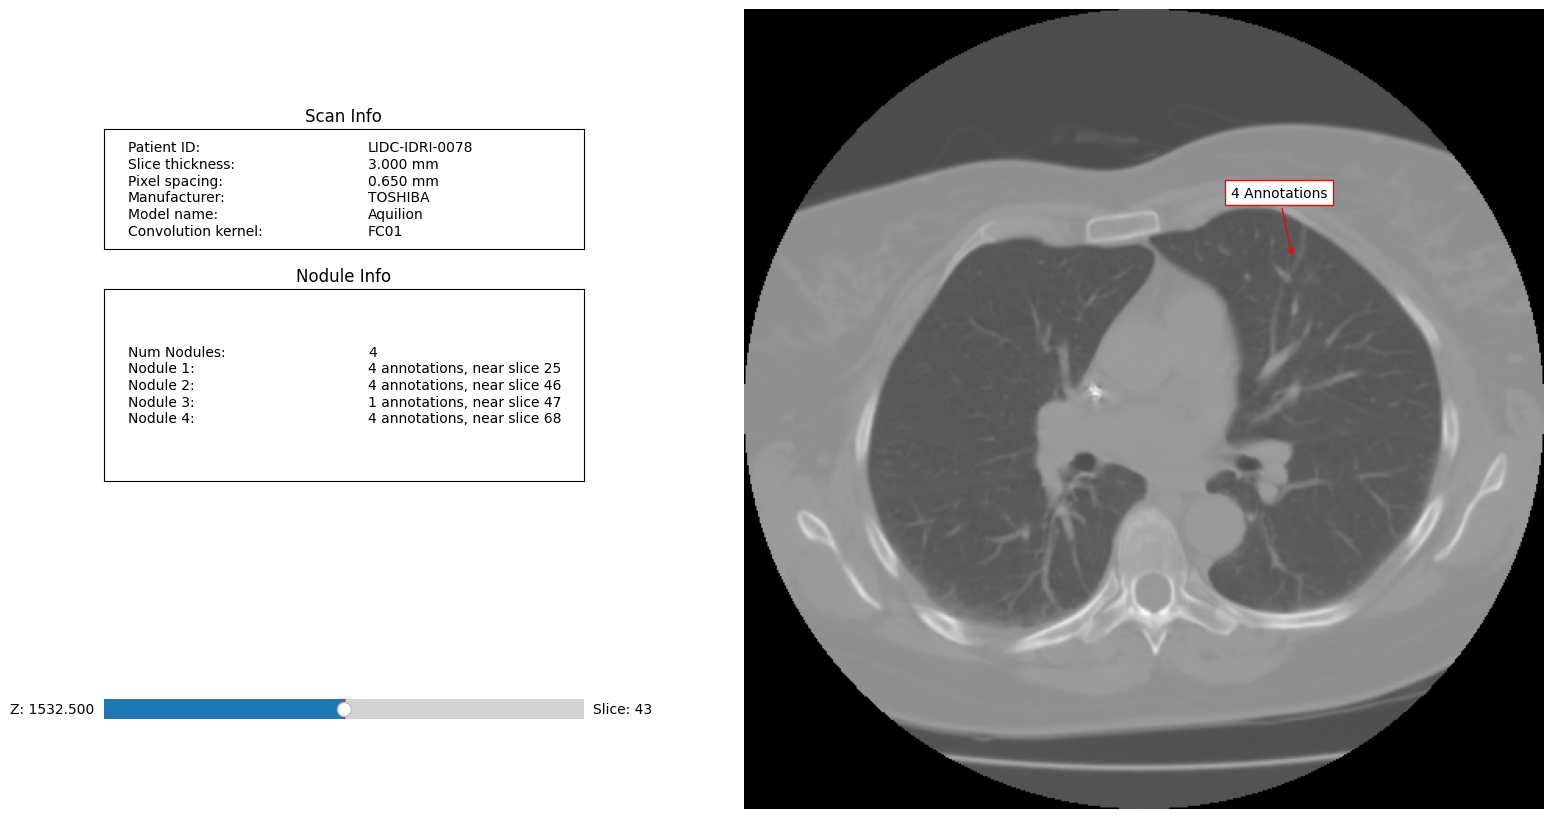

In [18]:
# Select the scan safely from the filtered scans list
scan = next(scan for scan in scans if scan.patient_id == "LIDC-IDRI-0078")

# Get the annotation groups (nodules) from that scan
nodules = scan.cluster_annotations()

# Visualize with contours
scan.visualize(annotation_groups=nodules)

### 2. Slices at 4 depths

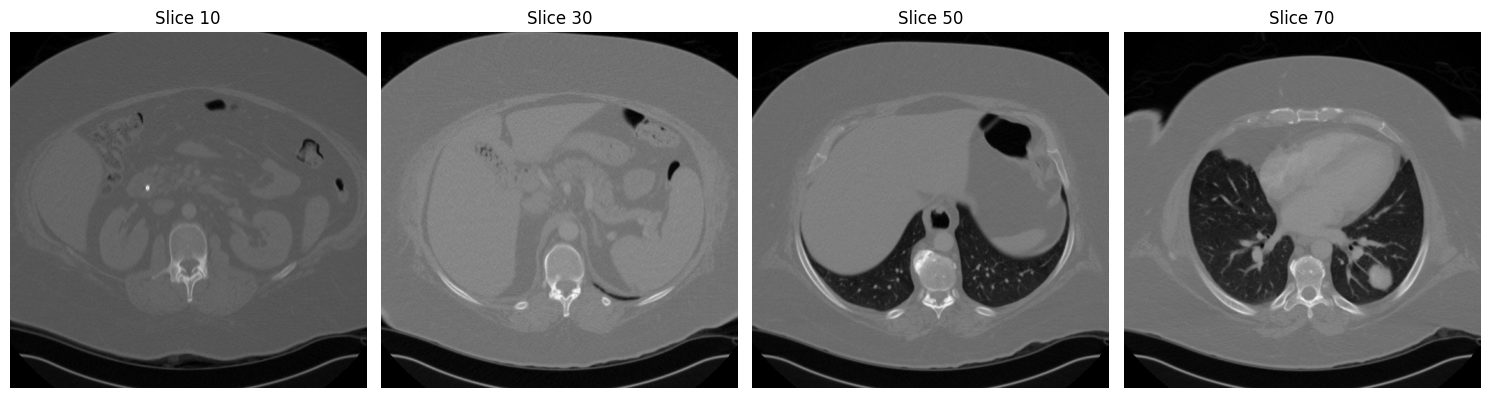

In [19]:
import matplotlib.pyplot as plt

# Pick some slice indices to view
slice_indices = [10, 30, 50, 70]

# Plot them
fig, axs = plt.subplots(1, len(slice_indices), figsize=(15, 5))

for i, idx in enumerate(slice_indices):
    axs[i].imshow(vol[:, :, idx], cmap='gray')
    axs[i].set_title(f"Slice {idx}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### 3. Interactive slider

In [20]:
# Select a scan from the filtered list (example: LIDC-IDRI-0078)
scan = next(scan for scan in scans if scan.patient_id == "LIDC-IDRI-0078")

# Get nodules (clustered annotations)
nodules = scan.cluster_annotations()

# Get volume and slice z-values
vol = scan.to_volume()
zvals = scan.slice_zvals

# Color map for nodules
colors = ['red', 'lime', 'cyan', 'orange', 'magenta', 'yellow', 'blue']

# Display function with contour overlay
def view_slice_with_nodules(z_index):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(vol[:, :, z_index], cmap='gray')

    z_pos = zvals[z_index]
    found = False

    for i, nodule in enumerate(nodules):
        color = colors[i % len(colors)]  # cycle colors
        for ann in nodule:
            for contour in ann.contours:
                if abs(contour.image_z_position - z_pos) < 1e-3:
                    ij = contour.to_matrix(include_k=False)
                    ax.plot(ij[:, 0], ij[:, 1], color=color, linewidth=2, label=f"Nodule {i+1}")
                    found = True

    ax.set_title(f"Slice {z_index} (z={z_pos:.2f})")
    ax.axis('off')
    if found:
        ax.legend(loc="upper right")
    plt.show()

# Interactive slider
slider = widgets.IntSlider(min=0, max=vol.shape[2] - 1, step=1, value=0)
widgets.interact(view_slice_with_nodules, z_index=slider)


Loading dicom files ... This may take a moment.


interactive(children=(IntSlider(value=0, description='z_index', max=86), Output()), _dom_classes=('widget-inte…

<function __main__.view_slice_with_nodules(z_index)>

## + Clean DataFrame of Annotations

In [21]:
data = []
for scan in scans:  # These are only the scans that exist on your disk
    for ann in scan.annotations:
        try:
            data.append({
                "patient_id": scan.patient_id,
                "annotation_id": ann.id,
                "malignancy": ann.malignancy,
                "sphericity": ann.sphericity,
                "texture": ann.texture,
                "margin": ann.margin,
                "lobulation": ann.lobulation,
                "spiculation": ann.spiculation,
                "calcification": ann.calcification,
                "subtlety": ann.subtlety,
                "internalStructure": ann.internalStructure,
                "level": ann.annotation_type,
            })
        except:
            continue

df = pd.DataFrame(data)

## + Pre-Processing

### Preprocessing Methods

In [22]:
import numpy as np
from scipy.ndimage import zoom

# Step 1: Load volume
def get_volume(scan):
    scan.load_all_dicom_images()  # Loads DICOMs into memory
    volume = scan.to_volume()     # Just one return value
    return volume

# Step 2: Normalize volume
def normalize_volume(volume):
    # Clip extreme values, then scale to 0-1
    volume = np.clip(volume, -1000, 400)
    volume = (volume - volume.min()) / (volume.max() - volume.min())
    return volume

# Step 3: Resample volume to 1mm spacing
# Old resampling
'''
def resample_volume(volume, scan, new_spacing=[1, 1, 1]):
    if isinstance(scan.pixel_spacing, float):
        current_spacing = [scan.pixel_spacing, scan.pixel_spacing, scan.slice_thickness]
    else:
        current_spacing = list(scan.pixel_spacing) + [scan.slice_thickness]
    
    current_spacing = current_spacing[::-1]  # [z, y, x]
    resize_factor = np.array(current_spacing) / np.array(new_spacing)
    
    resampled_volume = zoom(volume, resize_factor, order=0)
    return resampled_volume
'''
# New resampling
def resample_volume(volume, scan, new_spacing=[1, 1, 1], max_shape=(512, 512, 512)):
    # Determine current spacing (z, y, x)
    if isinstance(scan.pixel_spacing, float):
        current_spacing = [scan.pixel_spacing, scan.pixel_spacing, scan.slice_thickness]
    else:
        current_spacing = list(scan.pixel_spacing) + [scan.slice_thickness]

    current_spacing = current_spacing[::-1]  # [z, y, x]
    resize_factor = np.array(current_spacing) / np.array(new_spacing)
    new_shape = np.round(np.array(volume.shape) * resize_factor).astype(int)

    # Cap the maximum size to avoid massive zooming
    if any(n > m for n, m in zip(new_shape, max_shape)):
        print(f"Warning: Capping shape from {new_shape} to {max_shape} to avoid zooming too much.")
        new_shape = np.minimum(new_shape, max_shape)
        resize_factor = new_shape / np.array(volume.shape)

    resampled_volume = zoom(volume, resize_factor, order=1)
    return resampled_volume


# Step 4: HU Windowing
def apply_window(volume, center=-600, width=1500):
    lower = center - width // 2
    upper = center + width // 2
    return np.clip(volume, lower, upper)

# Step 5: Extract Nodule Region (Handling Missing Coordinates)
def extract_nodule_region(volume, scan, size=64):
    """
    Extract a cube around the nodule location from the volume.
    You must provide nodule centroid (in voxel coordinates).
    """
    # Check if nodule_center_voxel is present, if not, use dummy or skip
    if not hasattr(scan, 'nodule_center_voxel'):
        print(f"Warning: No nodule_center_voxel found for scan {scan.patient_id}. Skipping extraction.")
        return np.zeros((size, size, size))  # Return a default (empty) cube if no center voxel

    cz, cy, cx = scan.nodule_center_voxel
    half = size // 2

    z_start, z_end = max(0, cz-half), min(volume.shape[0], cz+half)
    y_start, y_end = max(0, cy-half), min(volume.shape[1], cy+half)
    x_start, x_end = max(0, cx-half), min(volume.shape[2], cx+half)

    return volume[z_start:z_end, y_start:y_end, x_start:x_end]


# Step 5: Padding
def pad_or_crop(volume, target_shape=(64, 64, 64), pad_value=-1000):
    current_shape = volume.shape
    padded_volume = np.full(target_shape, pad_value, dtype=volume.dtype)

    # Calculate cropping or padding indices
    z_min = max((target_shape[0] - current_shape[0]) // 2, 0)
    y_min = max((target_shape[1] - current_shape[1]) // 2, 0)
    x_min = max((target_shape[2] - current_shape[2]) // 2, 0)

    z_max = min(z_min + current_shape[0], target_shape[0])
    y_max = min(y_min + current_shape[1], target_shape[1])
    x_max = min(x_min + current_shape[2], target_shape[2])

    # Determine crop indices from original volume
    z_start = max((current_shape[0] - target_shape[0]) // 2, 0)
    y_start = max((current_shape[1] - target_shape[1]) // 2, 0)
    x_start = max((current_shape[2] - target_shape[2]) // 2, 0)

    z_end = z_start + (z_max - z_min)
    y_end = y_start + (y_max - y_min)
    x_end = x_start + (x_max - x_min)

    padded_volume[z_min:z_max, y_min:y_max, x_min:x_max] = volume[z_start:z_end, y_start:y_end, x_start:x_end]

    return padded_volume


### Testing without padding


In [23]:
'''import matplotlib.pyplot as plt

# Loop over first 3 scans to preprocess and visualize
for scan in dataset[:3]:
    print(f"\nProcessing {scan.patient_id}...")

    # Preprocessing pipeline
    volume = get_volume(scan)
    volume = apply_window(volume, center=-600, width=1500)
    volume = normalize_volume(volume)
    volume = resample_volume(volume, scan)
    
  # Choose slice indices to visualize (after resampling)
    depth = volume.shape[2]
    slice_indices = [depth // 5, depth // 2, (4 * depth) // 5]

    # Show each slice one at a time
    for idx in slice_indices:
        plt.figure(figsize=(5, 5))
        plt.imshow(volume[:, :, idx], cmap='gray')
        plt.title(f"{scan.patient_id} - Slice {idx}")
        plt.axis('off')
        plt.show()
'''

'import matplotlib.pyplot as plt\n\n# Loop over first 3 scans to preprocess and visualize\nfor scan in dataset[:3]:\n    print(f"\nProcessing {scan.patient_id}...")\n\n    # Preprocessing pipeline\n    volume = get_volume(scan)\n    volume = apply_window(volume, center=-600, width=1500)\n    volume = normalize_volume(volume)\n    volume = resample_volume(volume, scan)\n\n  # Choose slice indices to visualize (after resampling)\n    depth = volume.shape[2]\n    slice_indices = [depth // 5, depth // 2, (4 * depth) // 5]\n\n    # Show each slice one at a time\n    for idx in slice_indices:\n        plt.figure(figsize=(5, 5))\n        plt.imshow(volume[:, :, idx], cmap=\'gray\')\n        plt.title(f"{scan.patient_id} - Slice {idx}")\n        plt.axis(\'off\')\n        plt.show()\n'

### with padding


Processing LIDC-IDRI-0078...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


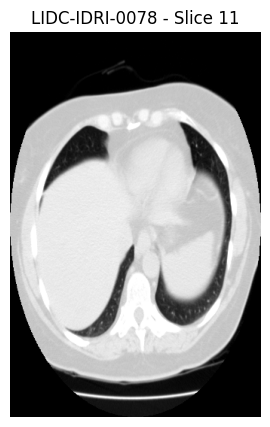

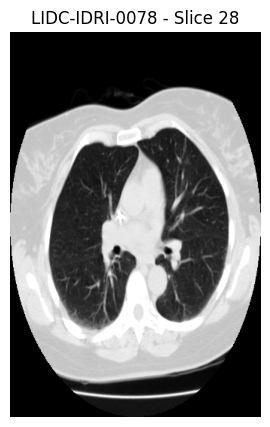

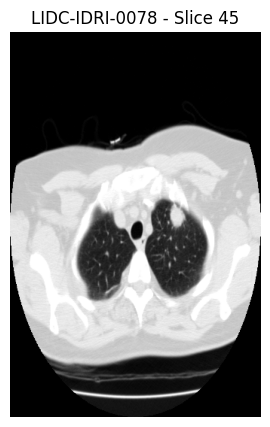


Processing LIDC-IDRI-0069...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


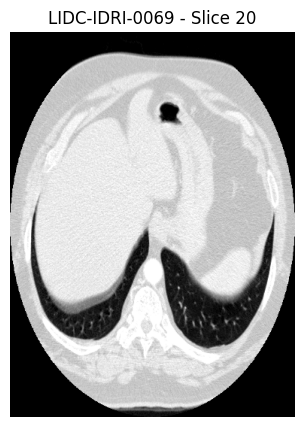

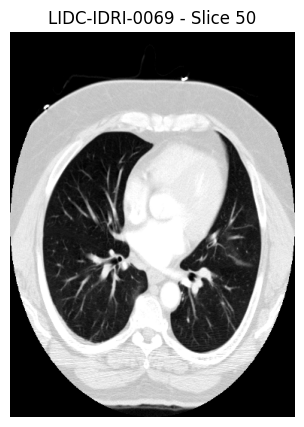

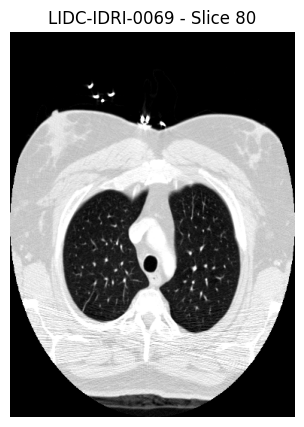


Processing LIDC-IDRI-0079...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


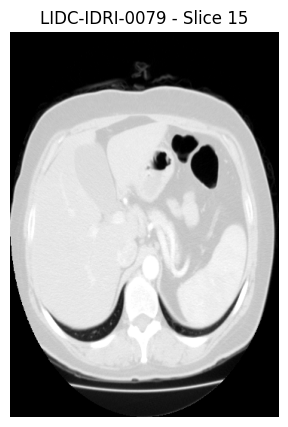

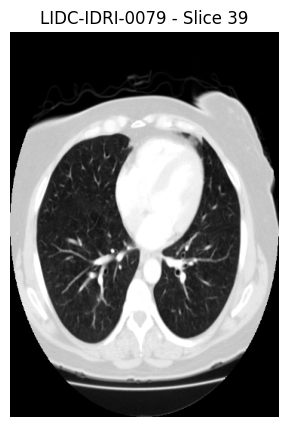

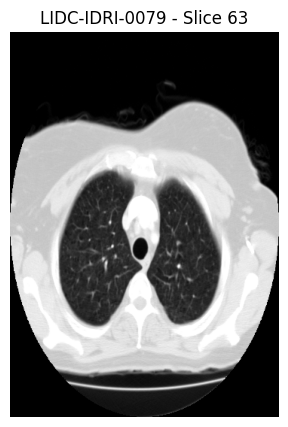

In [24]:
for scan in dataset[:3]:
    print(f"\nProcessing {scan.patient_id}...")

    # Preprocessing pipeline
    volume = get_volume(scan)
    volume = resample_volume(volume, scan)  # match spacing first
    volume = apply_window(volume, center=-600, width=1500)
    volume = normalize_volume(volume)
    
    # Extract nodule region (skip if nodule center is not found)
    #nodule_cube = extract_nodule_region(volume, scan)  # centered small box
    #cube_64 = pad_or_crop(nodule_cube, target_shape=(64, 64, 64), pad_value=0)

    nodule = extract_nodule_region(volume, scan)  # centered small box
    nodule = pad_or_crop(nodule, target_shape=(64, 64, 64), pad_value=0)
    
    # Choose slice indices to visualize
    depth = volume.shape[2]
    slice_indices = [depth // 5, depth // 2, (4 * depth) // 5]

    # Show each slice one at a time
    for idx in slice_indices:
        plt.figure(figsize=(5, 5))
        plt.imshow(volume[:, :, idx], cmap='gray', vmin=0, vmax=1)
        plt.title(f"{scan.patient_id} - Slice {idx}")
        plt.axis('off')
        plt.show()

## + Modeling test

In [25]:
import os
import numpy as np

# Folder and filenames
save_folder = "D:\Project_PIDS\LIDC_processed 2"
X_path = os.path.join(save_folder, "X.npy")
y_path = os.path.join(save_folder, "y.npy")

# Check if preprocessed data already exists
if os.path.exists(X_path) and os.path.exists(y_path):
    print("📂 Found preprocessed files! Loading them...")
    X = np.load(X_path)
    y = np.load(y_path)
    print(f"✅ Loaded! Samples: {len(X)}, Shape: {X.shape}, Labels: {dict(zip(*np.unique(y, return_counts=True)))}")
else:
    print("⚙️ No preprocessed files found. Running full preprocessing...")

    volumes = []
    labels = []

    for scan in dataset:
        print(f"📂 Processing scan {scan.patient_id}...")

        try:
            volume = get_volume(scan)
            volume = normalize_volume(volume)
            volume = resample_volume(volume, scan)
            volume = apply_window(volume)
        except Exception as e:
            print(f"❌ Failed volume preprocessing for {scan.patient_id}: {e}")
            continue

        if scan.annotations:
            ann = scan.annotations[0]
            centroid = ann.centroid
            if centroid is not None:
                scan.nodule_center_voxel = tuple(int(round(c)) for c in centroid)

        nodule = extract_nodule_region(volume, scan)

        if nodule is None or nodule.sum() == 0:
            print(f"⚠️ Empty or missing nodule region in {scan.patient_id}. Skipping.")
            continue

        nodule = pad_or_crop(nodule)

        try:
            malignancies = [a.malignancy for a in scan.annotations if hasattr(a, 'malignancy')]
            if len(malignancies) == 0:
                print(f"⚠️ No malignancy scores for {scan.patient_id}. Skipping.")
                continue
            malignancy = np.median(malignancies)
            label = int(round(malignancy)) >= 4
        except Exception as e:
            print(f"❌ Label extraction failed for {scan.patient_id}: {e}")
            continue

        volumes.append(nodule)
        labels.append(label)

        print(f"✅ {scan.patient_id} | Malignancy: {malignancy:.1f} → Label: {label} | Nodule shape: {nodule.shape}")

    # Convert to NumPy arrays
    X = np.array(volumes)[..., np.newaxis]  # shape: (N, 64, 64, 64, 1)
    y = np.array(labels)                    # shape: (N,)

    # Save the results
    os.makedirs(save_folder, exist_ok=True)
    np.save(X_path, X)
    np.save(y_path, y)

    print(f"\n🎉 Done! Dataset ready — Samples: {len(X)}, Shape: {X.shape}, Label distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
    print(f"💾 Saved to '{save_folder}' folder!")

<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Asus\AppData\Local\Temp\ipykernel_26404\2050190364.py:5: SyntaxWarning: invalid escape sequence '\P'
  save_folder = "D:\Project_PIDS\LIDC_processed 2"


📂 Found preprocessed files! Loading them...
✅ Loaded! Samples: 471, Shape: (471, 64, 64, 64, 1), Labels: {False: 360, True: 111}


In [26]:
# STEP 2 : train/split 
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
'''# Step 3: Build 3D CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Flatten, Dropout, BatchNormalization

model = Sequential([
    Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(64, 64, 64, 1)),
    MaxPooling3D(pool_size=(2,2,2)),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2)),
    BatchNormalization(),

    Conv3D(128, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
'''

"# Step 3: Build 3D CNN\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Flatten, Dropout, BatchNormalization\n\nmodel = Sequential([\n    Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(64, 64, 64, 1)),\n    MaxPooling3D(pool_size=(2,2,2)),\n    BatchNormalization(),\n\n    Conv3D(64, kernel_size=(3,3,3), activation='relu'),\n    MaxPooling3D(pool_size=(2,2,2)),\n    BatchNormalization(),\n\n    Conv3D(128, kernel_size=(3,3,3), activation='relu'),\n    MaxPooling3D(pool_size=(2,2,2)),\n    BatchNormalization(),\n\n    Flatten(),\n    Dense(128, activation='relu'),\n    Dropout(0.5),\n    Dense(1, activation='sigmoid')\n])\n\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\nmodel.summary()\n"

In [28]:
# Step 3: Build 3D CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling3D
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # Watch validation loss
    patience=3,             # kenet 5
    restore_best_weights=True  # Recover best model weights
)

model = Sequential([
    Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=(64, 64, 64, 1)),
    MaxPooling3D(pool_size=(2,2,2)),
    Dropout(0.4),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2)),
    Dropout(0.4),
    BatchNormalization(),

    Conv3D(128, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2)),
    Dropout(0.4),
    BatchNormalization(),

    GlobalAveragePooling3D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) #kenet -4
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
model.summary()


C:\envs\lidc-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 62, 62, 62, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 31, 31, 31, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 31, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 31, 31, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 29, 29, 29, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 14, 14, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 14, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 12, 12, 12, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 6, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 6, 6, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 295,105 (1.13 MB)

 Trainable params: 294,657 (1.12 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique_val, counts_val = np.unique(y_val, return_counts=True)
print(dict(zip(unique_val, counts_val)))

{False: 287, True: 89}
{False: 73, True: 22}


In [30]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.6550522648083623, 1: 2.1123595505617976}


In [31]:
# Step 4: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    class_weight=class_weight_dict,
    batch_size=8
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6429 - auc: 0.4924 - loss: 0.7155 - precision: 0.2880 - recall: 0.3599 - val_accuracy: 0.6421 - val_auc: 0.6336 - val_loss: 0.6631 - val_precision: 0.3421 - val_recall: 0.5909
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6455 - auc: 0.6185 - loss: 0.6874 - precision: 0.3702 - recall: 0.5962 - val_accuracy: 0.7684 - val_auc: 0.6625 - val_loss: 0.6298 - val_precision: 0.5000 - val_recall: 0.1818
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6802 - auc: 0.6164 - loss: 0.6801 - precision: 0.3888 - recall: 0.5773 - val_accuracy: 0.7368 - val_auc: 0.6893 - val_loss: 0.6184 - val_precision: 0.2000 - val_recall: 0.0455
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6931 - auc: 0.6356 - loss: 0.6309 - precision: 0.3287 - recall: 0.5302 - val_accuracy: 0.7263 - val_auc: 0.6663 - val_loss: 0.6229 - val_precision: 0.3333 - val_recall: 0.1818
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 63

## + Evaluation

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


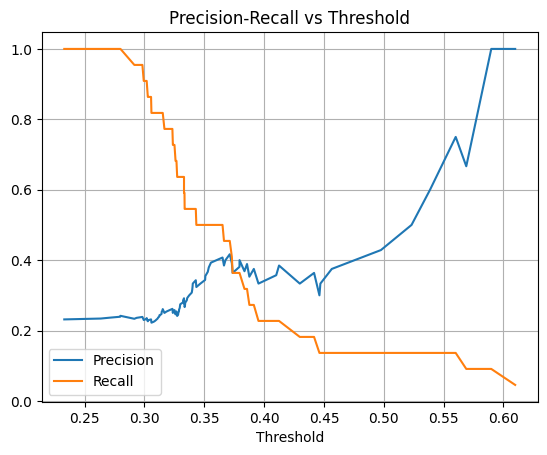

In [33]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get the probabilities
y_pred_probs = model.predict(X_val).ravel()

# Get precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_probs)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.title('Precision-Recall vs Threshold')
plt.show()


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have test data:
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Apply threshold
#y_pred = (y_pred_prob > 0.32).astype("int32")  # Apply threshold

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report (precision, recall, f1-score, accuracy)
print('Classification Report:')
print(classification_report(y_val, y_pred, digits=4))


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Confusion Matrix:
[[70  3]
 [19  3]]
Classification Report:
              precision    recall  f1-score   support

       False     0.7865    0.9589    0.8642        73
        True     0.5000    0.1364    0.2143        22

    accuracy                         0.7684        95
   macro avg     0.6433    0.5476    0.5392        95
weighted avg     0.7202    0.7684    0.7137        95



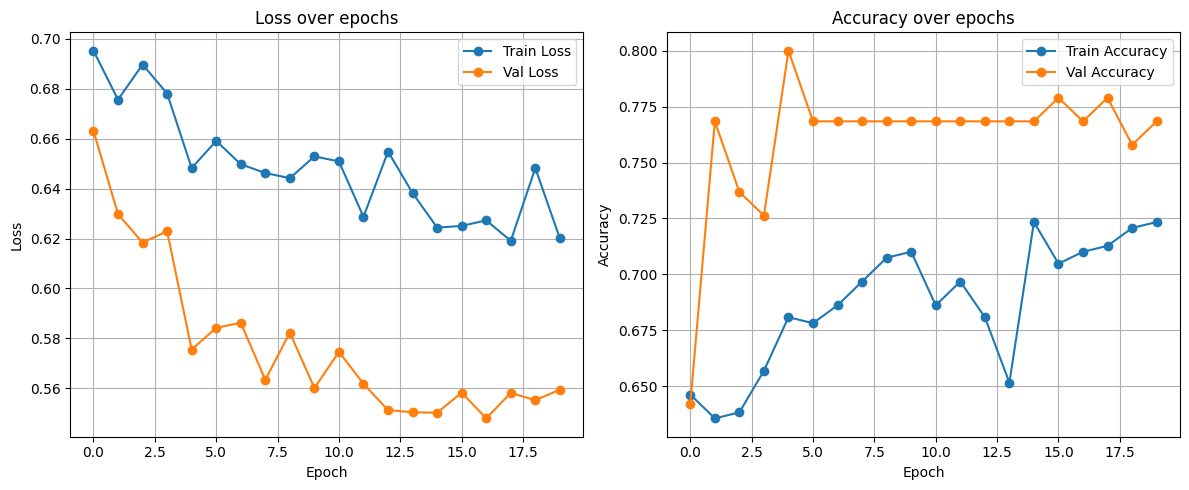

In [36]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


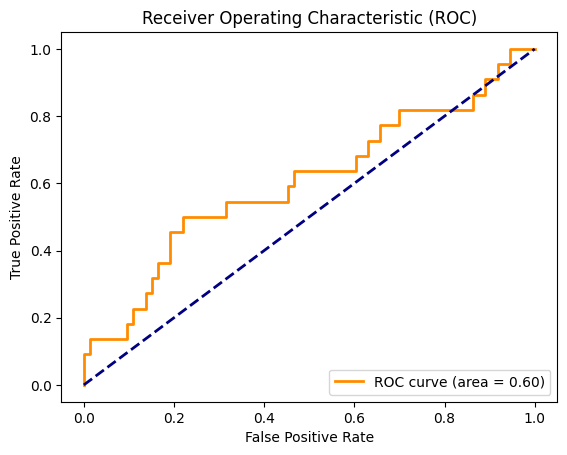

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
!pip install seaborn